In [ ]:
# Name: Muhammad Junaid Iftikhar
# Roll Number: Ezi-ML-B1-161
# TASK 07 Recursive Feature Elimination


**Importing all dependecies for the project**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    confusion_matrix,roc_curve,roc_auc_score,precision_recall_curve,average_precision_score, confusion_matrix, ConfusionMatrixDisplay,
     classification_report, accuracy_score
)
import warnings
warnings.filterwarnings('ignore')


**Reading csv file**

In [ ]:


df = pd.read_csv("Titanic-Dataset - Copy.csv")

In [ ]:
to_drop = [
    'PassengerId','Name','Ticket','Cabin','PassengerId_LE','Name_LE','Ticket_LE','Cabin_LE',
    'Age_scaled','Fare_scaled','SibSp_scaled','Parch_scaled'
]

df.drop(columns=to_drop,inplace=True) # changing in orignal data frame


In [ ]:

df['IsAlone'] = (df['FamilySize']==1).astype(int)
df['AgeGroup']=pd.cut(df['Age'], bins=[0,12,18,60,100],
                       labels= ['Child','Teen','Adult','Senior'])
df['FareGroup']= pd.qcut(df['Fare'], q=4, labels=['Low','Medium','High','VeryHigh'])
df['IsMale']= (df['Sex']=='male').astype(int)

In [ ]:

title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)
cat_cols = ['Deck','Embarked','Title','AgeGroup','FareGroup']
df_encoded = pd.get_dummies(df[cat_cols],drop_first=True)

In [ ]:


num_cols = ['Age','Fare']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[num_cols])
df_scaled = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in num_cols])


In [ ]:
final_features = pd.concat([
    df[['Pclass','IsMale','FamilySize','IsAlone','Survived']],
    df_encoded,
    df_scaled
],axis=1)


In [ ]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title,FamilySize,IsAlone,AgeGroup,FareGroup,IsMale
0,0,3,male,22.0,1,0,7.2500,S,U,Mr,2,0,Adult,Low,1
1,1,1,female,38.0,1,0,71.2833,C,C,Mrs,2,0,Adult,VeryHigh,0
2,1,3,female,26.0,0,0,7.9250,S,U,Miss,1,1,Adult,Medium,0
3,1,1,female,35.0,1,0,53.1000,S,C,Mrs,2,0,Adult,VeryHigh,0
4,0,3,male,35.0,0,0,8.0500,S,U,Mr,1,1,Adult,Medium,1


In [ ]:
X = final_features.drop('Survived',axis=1)
Y = final_features['Survived']

In [ ]:

rfe = RFE(estimator=DecisionTreeClassifier(),n_features_to_select=5)

In [ ]:
X_rfe = rfe.fit_transform(X, Y)


In [ ]:
for i,col in zip(range(X.shape[1]), X.columns):
  print(f"{col} selected = {rfe.support_[i]} rank={rfe.ranking_[i]}")



Pclass selected = True rank=1
IsMale selected = False rank=3
FamilySize selected = True rank=1
IsAlone selected = False rank=11
Deck_B selected = False rank=8
Deck_C selected = False rank=12
Deck_D selected = False rank=10
Deck_E selected = False rank=22
Deck_F selected = False rank=18
Deck_G selected = False rank=20
Deck_T selected = False rank=21
Deck_U selected = False rank=6
Embarked_Q selected = False rank=15
Embarked_S selected = False rank=5
Title_Miss selected = False rank=13
Title_Mr selected = True rank=1
Title_Mrs selected = False rank=19
Title_Rare selected = False rank=2
AgeGroup_Teen selected = False rank=9
AgeGroup_Adult selected = False rank=4
AgeGroup_Senior selected = False rank=17
FareGroup_Medium selected = False rank=7
FareGroup_High selected = False rank=16
FareGroup_VeryHigh selected = False rank=14
Age_scaled selected = True rank=1
Fare_scaled selected = True rank=1


In [ ]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Train baseline model
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_base = baseline_model.predict(X_test)

# Evaluation
print("Baseline Model Performance (all features):")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print(classification_report(y_test, y_pred_base))


Baseline Model Performance (all features):
Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       105
           1       0.79      0.81      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



In [ ]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_rfe, Y, test_size=0.2, random_state=42)

# Train model with selected features
reduced_model = DecisionTreeClassifier(random_state=42)
reduced_model.fit(X_train_rfe, y_train_rfe)

# Predictions
y_pred_rfe = reduced_model.predict(X_test_rfe)

# Evaluation
print("\nReduced Model Performance (RFE-selected features):")
print("Accuracy:", accuracy_score(y_test_rfe, y_pred_rfe))
print(classification_report(y_test_rfe, y_pred_rfe))


Reduced Model Performance (RFE-selected features):
Accuracy: 0.7430167597765364
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       105
           1       0.68      0.73      0.70        74

    accuracy                           0.74       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.75      0.74      0.74       179



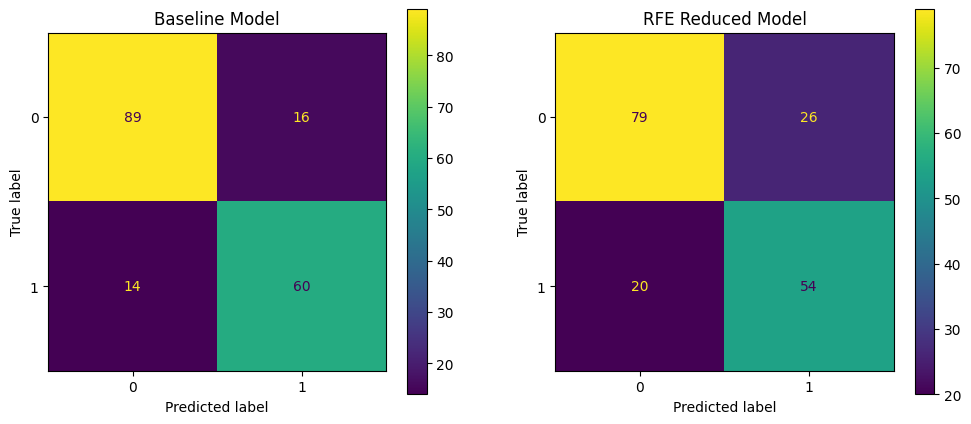

In [ ]:
# Confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_base, ax=ax[0])
ax[0].set_title("Baseline Model")

ConfusionMatrixDisplay.from_predictions(y_test_rfe, y_pred_rfe, ax=ax[1])
ax[1].set_title("RFE Reduced Model")

plt.show()